##### top

# This ntb is simply processing all the csv files and creating one csv per all conditions

* [Unbiased C](#Unbiased-C)
* [Estimate C error per all combinations of N and n trials](#Estimate-C-error-per-all-combinations-of-N-and-n-trials)
  * [estimate STD](#STD)
  
  
Note that the C coefficient was previously called "BA" and that is used in this script for compatibility purposes.

In [1]:
import os, sys
import time
import numpy as np
import pandas as pd

path_results = "../Data/results" 
path_curve_fit = os.path.join(path_results, "curve_fits")
path_simulation_general = os.path.join(path_curve_fit, "compare_fitting_methods")


def compute_fit_distances4fits(df, sigma_thr_gauss=0.01, sigma_thr_lognorm=0.1, true_BA="true_BA"):
    """
    Compute distances from the true BA value by subtracting that value from each of the fits, add label for small sigmas.
    """
    
    # add difference
    df["fit_hyperbolic_dist"] = df["hyperbolic_fit"] - df[true_BA]
    df["fit_linear_dist"] = df["fit_linear_slope"] - df[true_BA]
    df["fit_theoretical_dist"] = df["fit_theoretical"] - df[true_BA]
    if "fit_theoretical_unbiased" in df.columns:
        df["fit_theoretical_unbiased_dist"] = df["fit_theoretical_unbiased"] - df[true_BA]

    # add a label for small sigma
    if "sigma" in df.columns:
        df["small_sigma"] = False
        df.loc[(df["distribution"]=="gaussian")&(df["sigma"]<=sigma_thr_gauss),"small_sigma"] = True
        df.loc[(df["distribution"]=="lognormal")&(df["sigma"]<=sigma_thr_lognorm),"small_sigma"] = True

        # more transparency
        if df['small_sigma'].any():
            print('we have some small sigma')
    
    return df

def process_varying_N(path_simulation, total_n_trials, 
                      BA_min=2, BA_max=50, sigma_thr_gauss=0.01, sigma_thr_lognorm=0.1, save=True, true_BA="true_BA"):
    """
    Go over all folders with different N, extract csv files with different parameter values (different simulations),
    concatenate them, process them (add distance from true BA), check that we have all values and save this DataFrame.
    Also, restrict the result to have BA values between given range.
    """
    
    # get all names
    folders = [x for x in os.listdir(path_simulation) if os.path.isdir(os.path.join(path_simulation,x))]

    # create a big df
    df = pd.DataFrame()

    for folder in folders:
        csv_files = [x for x in os.listdir(os.path.join(path_simulation, folder)) if x.endswith('.csv')]
        for file in csv_files:
            df = df.append(pd.read_csv(os.path.join(path_simulation, folder, file)))

    # compute differences from the true coefficient
    df = compute_fit_distances4fits(df, sigma_thr_gauss=sigma_thr_gauss, sigma_thr_lognorm=sigma_thr_lognorm, true_BA=true_BA)

    # check N
    assert len(folders) == len(df['N'].unique())
    assert set(df['N'].unique()) == set([int(x) for x in folders])
    print(f'There is {len(df["N"].unique())} Ns.')

    # select BAs that we care about
    df = df.loc[(df[true_BA]>=BA_min)&(df[true_BA]<=BA_max)]

    # save this selection
    if save:
        df.to_csv(os.path.join(path_simulation, f"all_simulations_varyN_ntrials_{total_n_trials}_{true_BA.split('_')[-1]}_between_{BA_min}-{BA_max}.csv"), index=False)
    
    return df


def process_varying_ntrials(path_simulation, N, 
                      BA_min=2, BA_max=50, sigma_thr_gauss=0.01, sigma_thr_lognorm=0.1, save=True, true_BA="true_BA"):
    """
    Go over all folders with different n trials, extract csv files with different parameter values (different simulations),
    concatenate them, process them (add distance from true BA), check that we have all values and save this DataFrame.
    Also, restrict the result to have BA values between given range.
    """
    
    # get all names
    folders = [x for x in os.listdir(path_simulation) if os.path.isdir(os.path.join(path_simulation,x))]

    # create a big df
    df = pd.DataFrame()

    for folder in folders:
        csv_files = [x for x in os.listdir(os.path.join(path_simulation, folder)) if x.endswith('.csv')]
        for file in csv_files:
            tmp = pd.read_csv(os.path.join(path_simulation, folder, file))
            tmp["total_n_trials"] = int(folder)
            df = df.append(tmp)

    # compute differences from the true coefficient
    df = compute_fit_distances4fits(df, sigma_thr_gauss=sigma_thr_gauss, sigma_thr_lognorm=sigma_thr_lognorm, true_BA=true_BA)

    # check N
    assert len(folders) == len(df['total_n_trials'].unique())
    assert set(df['total_n_trials'].unique()) == set([int(x) for x in folders])
    print(f'There is {len(df["total_n_trials"].unique())} number of trials.')

    # select BAs that we care about
    df = df.loc[(df[true_BA]>=BA_min)&(df[true_BA]<=BA_max)]

    # save this selection
    if save:
        df.to_csv(os.path.join(path_simulation, f"all_simulations_varyntrials_N_{N}_{true_BA.split('_')[-1]}_between_{BA_min}-{BA_max}.csv"), index=False)
    
    return df


def create_median_error_df(df, path_simulation=None, suffix='', vary_col='N', const_col='total_n_trials', 
                           groupby_cols=['N','true_BA'], remove_problematics=True, true_BA="true_BA"):
    
    # check that we do not have a mismatch
    assert vary_col in groupby_cols
    
    # get df with BA median
    if "small_sigma" in df.columns and remove_problematics:
        df_BA_median_varyN = df[~df["small_sigma"]].groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_BA_std_per_N_varyN = df.loc[~df["small_sigma"], 
                                       groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist"]
                                      ].groupby(groupby_cols).std().reset_index()
        
    if "exploded" in df.columns and remove_problematics:
        df_BA_median_varyN = df[df["exploded"]==0].groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_BA_std_per_N_varyN = df.loc[df["exploded"]==0, 
                                       groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist"]
                                      ].groupby(groupby_cols).std().reset_index()
        
    else:
        df_BA_median_varyN = df.groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_BA_std_per_N_varyN = df.loc[:, groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist"]
                                      ].groupby(groupby_cols).std().reset_index()


    # get median percent error
    df_perc_median_varyN = pd.DataFrame({
        "fit": len(df_BA_median_varyN)*['hyperbolic'] + len(df_BA_median_varyN)*['linear'] + len(df_BA_median_varyN)*['theory'],
        "percent_error": np.concatenate([
            (df_BA_median_varyN["fit_hyperbolic_dist"]/df_BA_median_varyN[true_BA]).values, 
            (df_BA_median_varyN["fit_linear_dist"]/df_BA_median_varyN[true_BA]).values,
            (df_BA_median_varyN["fit_theoretical_dist"]/df_BA_median_varyN[true_BA]).values,
        ]),
        "percent_error_std_perN": np.concatenate([
            (df_BA_std_per_N_varyN["fit_hyperbolic_dist"]/df_BA_median_varyN[true_BA]).values, 
            (df_BA_std_per_N_varyN["fit_linear_dist"]/df_BA_median_varyN[true_BA]).values,
            (df_BA_std_per_N_varyN["fit_theoretical_dist"]/df_BA_median_varyN[true_BA]).values,
        ]),
        f"{vary_col}": np.tile(df_BA_median_varyN[vary_col].values, 3),
        f"{const_col}": np.tile(df_BA_median_varyN[const_col].values, 3),
        "true_BA": np.tile(df_BA_median_varyN["true_BA"].values, 3),
        "mu_lognorm": np.tile(df_BA_median_varyN["mu_lognorm"].values, 3),
    })
    # NOTE here that I also compute the std per N per true BA and then convert that to percents by dividing it by the
    # true BA. 
    df_perc_median_varyN["distribution"] = df_perc_median_varyN["mu_lognorm"].isna().map({True:"gaussian", False:"lognormal"})

    df_perc_median_varyN["percent_error"] *= 100
    df_perc_median_varyN["percent_error_std_perN"] *= 100

    df_perc_median_varyN["percent_error_abs"] = df_perc_median_varyN["percent_error"].abs()
    
    df_perc_median_varyN.drop(columns=["mu_lognorm"], inplace=True)
    
    # save if path was provided
    if path_simulation is not None:
        df_perc_median_varyN.to_csv(os.path.join(path_simulation, f"df_perc_median_vary{vary_col}{suffix}.csv"), index=False)


    return df_perc_median_varyN


    
def create_mean_error_df(df, path_simulation=None, suffix='', vary_col='N', const_col='total_n_trials', groupby_cols=['N','true_BA']):
    
    # check that we do not have a mismatch
    assert vary_col in groupby_cols
    
    if "small_sigma" in df.columns:
        # get df with BA mean
        df_BA_mean_varyN = df[~df["small_sigma"]].groupby(groupby_cols).mean().reset_index()
        # get also std per N
        df_BA_std_per_N_varyN = df.loc[~df["small_sigma"], 
                                       groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist"]
                                      ].groupby(groupby_cols).std().reset_index()
    else:
        # get df with BA mean
        df_BA_mean_varyN = df.groupby(groupby_cols).mean().reset_index()
        # get also std per N
        df_BA_std_per_N_varyN = df.loc[:, groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist"]
                                      ].groupby(groupby_cols).std().reset_index()


    # get mean percent error
    df_perc_mean_varyN = pd.DataFrame({
        "fit": len(df_BA_mean_varyN)*['hyperbolic'] + len(df_BA_mean_varyN)*['linear'] + len(df_BA_mean_varyN)*['theory'],
        "percent_error": np.concatenate([
            (df_BA_mean_varyN["fit_hyperbolic_dist"]/df_BA_mean_varyN["true_BA"]).values, 
            (df_BA_mean_varyN["fit_linear_dist"]/df_BA_mean_varyN["true_BA"]).values,
            (df_BA_mean_varyN["fit_theoretical_dist"]/df_BA_mean_varyN["true_BA"]).values,
        ]),
        "percent_error_std_perN": np.concatenate([
            (df_BA_std_per_N_varyN["fit_hyperbolic_dist"]/df_BA_mean_varyN["true_BA"]).values, 
            (df_BA_std_per_N_varyN["fit_linear_dist"]/df_BA_mean_varyN["true_BA"]).values,
            (df_BA_std_per_N_varyN["fit_theoretical_dist"]/df_BA_mean_varyN["true_BA"]).values,
        ]),
        f"{vary_col}": np.tile(df_BA_mean_varyN[vary_col].values, 3),
        f"{const_col}": np.tile(df_BA_mean_varyN[const_col].values, 3),
        "true_BA": np.tile(df_BA_mean_varyN["true_BA"].values, 3),
        "mu_lognorm": np.tile(df_BA_mean_varyN["mu_lognorm"].values, 3),
    })
    # NOTE here that I also compute the std per N per true BA and then convert that to percents by dividing it by the
    # true BA. 
    df_perc_mean_varyN["distribution"] = df_perc_mean_varyN["mu_lognorm"].isna().map({True:"gaussian", False:"lognormal"})

    df_perc_mean_varyN["percent_error"] *= 100
    df_perc_mean_varyN["percent_error_std_perN"] *= 100

    df_perc_mean_varyN["percent_error_abs"] = df_perc_mean_varyN["percent_error"].abs()
    
    df_perc_mean_varyN.drop(columns=["mu_lognorm"], inplace=True)
    
    # save if path was provided
    if path_simulation is not None:
        df_perc_mean_varyN.to_csv(os.path.join(path_simulation, f"df_perc_mean_vary{vary_col}{suffix}.csv"), index=False)


    return df_perc_mean_varyN

### Unbiased C
[top](#top)

In [2]:
def process_percent_error(csv_files, path_simulation, true_C="true_C", C_min=1, C_max=100,
                          fit_dist_list=['fit_hyperbolic_dist', 'fit_linear_dist', 'fit_theoretical_dist', 'fit_theoretical_unbiased_dist'],
                          total_n_trials=250, remove_problematics=True):
    
    # create helper df
    df_median = pd.DataFrame()
    df_mean = pd.DataFrame()
    
    for file in csv_files:
        # load and process them one by one and process to reduce memory load
        df = pd.read_csv(os.path.join(path_simulation, file))
        
        assert df[true_C].unique().size == 1
        assert df["N"].unique().size == 1
        
        # check for Cs
        if C_min <= df[true_C].unique()[0] <= C_max:

            # get distances
            df = compute_fit_distances4fits(df, true_BA=true_C)

            # go over all the fits
            for col in fit_dist_list:
                df[f"{col}_perc"] = 100*(df[col]/df[true_C]).values

            if "exploded" in df.columns and remove_problematics:
                # set exploded trials to be nans in the given column
                df.loc[df["exploded"]==1, "fit_theoretical_unbiased_dist_perc"] = np.nan
                # TODO check


            # compute the median error
            df_median_tmp = df.loc[:, [f"{x}_perc" for x in fit_dist_list]].median().reset_index().rename(columns={"index":"fit", 0:"percent_error"})
            df_median_tmp = pd.merge(df_median_tmp,
                                     df.loc[:, [f"{x}_perc" for x in fit_dist_list]].std().reset_index().rename(columns={"index":"fit", 0:"percent_error_std_perN"}),
                                     on="fit")

            # compute the mean error
            df_mean_tmp = df.loc[:, [f"{x}_perc" for x in fit_dist_list]].mean().reset_index().rename(columns={"index":"fit", 0:"percent_error"})
            df_mean_tmp = pd.merge(df_mean_tmp,
                                     df.loc[:, [f"{x}_perc" for x in fit_dist_list]].std().reset_index().rename(columns={"index":"fit", 0:"percent_error_std_perN"}),
                                     on="fit")

            # add variables and make naming consistent        
            for d in [df_median_tmp, df_mean_tmp]:
                d["fit"] = d["fit"].str.replace("_dist_perc", "").str.replace("fit_", "").str.replace("theoretical","theory")
                d[true_C] = df[true_C].unique()[0]
                d["N"] = df["N"].unique()[0]
                d["total_n_trials"] = total_n_trials
                d["distribution"] = df["distribution"].unique()[0]

            # save
            df_median = pd.concat([df_median, df_median_tmp])
            df_mean = pd.concat([df_mean, df_mean_tmp])
            
        else:
            print(f"C of {df[true_C].unique()[0]} is not within the range {C_min} - {C_max}")
            continue
        
    return df_median, df_mean

In [3]:
total_n_trials = 250
path_simulation = os.path.join(path_simulation_general, f'beta_simulate_N_ntrials{total_n_trials}')
# remove explosions
remove_problematics = True 

# define relevant range
C_min=1
C_max=100

# create helper df
df_median = pd.DataFrame()
df_mean = pd.DataFrame()

# get the folders and sort the order
folders = sorted([x for x in os.listdir(path_simulation) if os.path.isdir(os.path.join(path_simulation,x))], key=lambda x: int(x))

for folder in folders:
    df1, df2 = None, None
    # get all the files
    csv_files = [x for x in os.listdir(os.path.join(path_simulation, folder)) if x.endswith('.csv')]

    # get percent error
    df1, df2 = process_percent_error(csv_files, os.path.join(path_simulation, folder), C_min=C_min, C_max=C_max,
                                     total_n_trials=total_n_trials, remove_problematics=remove_problematics)

    # save
    df_median = pd.concat([df_median, df1])
    df_mean = pd.concat([df_mean, df2])


# save to csv
if remove_problematics:
    df_median.sort_values(by=["fit", "true_C", "N"]).to_csv(os.path.join(path_simulation, f"df_perc_median_noexplosions_varyN_ntrials_{total_n_trials}_unbiasedC_between_{C_min}-{C_max}.csv"), index=False)
    df_mean.sort_values(by=["fit", "true_C", "N"]).to_csv(os.path.join(path_simulation, f"df_perc_mean_noexplosions_varyN_ntrials_{total_n_trials}_unbiasedC_between_{C_min}-{C_max}.csv"), index=False)

else:
    df_median.sort_values(by=["fit", "true_C", "N"]).to_csv(os.path.join(path_simulation, f"df_perc_median_varyN_ntrials_{total_n_trials}_unbiasedC_between_{C_min}-{C_max}.csv"), index=False)
    df_mean.sort_values(by=["fit", "true_C", "N"]).to_csv(os.path.join(path_simulation, f"df_perc_mean_varyN_ntrials_{total_n_trials}_unbiasedC_between_{C_min}-{C_max}.csv"), index=False)

    

In [4]:
df_mean.sort_values(by=["fit", "true_C"])

,fit,percent_error,percent_error_std_perN,true_C,N,total_n_trials,distribution
0,hyperbolic,13.673304,74.509603,2.000449,10,250,beta
0,hyperbolic,3.750132,34.855750,2.000449,20,250,beta
0,hyperbolic,1.775915,26.135887,2.000449,30,250,beta
0,hyperbolic,1.738074,22.566519,2.000449,40,250,beta
0,hyperbolic,1.499348,19.995133,2.000449,50,250,beta
...,...,...,...,...,...,...,...
3,theory_unbiased,3.161006,16.130513,79.963307,160,250,beta
3,theory_unbiased,2.888578,15.657380,79.963307,170,250,beta
3,theory_unbiased,2.853626,15.207788,79.963307,180,250,beta
3,theory_unbiased,2.698342,14.582700,79.963307,190,250,beta


In [5]:
df_median.loc[df_median["fit"]=="theory_unbiased"].sort_values(by=["fit", "true_C"])

,fit,percent_error,percent_error_std_perN,true_C,N,total_n_trials,distribution
3,theory_unbiased,15.686661,89.406823,2.000449,10,250,beta
3,theory_unbiased,5.430435,37.745003,2.000449,20,250,beta
3,theory_unbiased,3.606910,27.541641,2.000449,30,250,beta
3,theory_unbiased,2.704611,23.417794,2.000449,40,250,beta
3,theory_unbiased,2.165054,20.578308,2.000449,50,250,beta
...,...,...,...,...,...,...,...
3,theory_unbiased,1.475483,16.130513,79.963307,160,250,beta
3,theory_unbiased,1.426967,15.657380,79.963307,170,250,beta
3,theory_unbiased,1.202220,15.207788,79.963307,180,250,beta
3,theory_unbiased,1.429276,14.582700,79.963307,190,250,beta


#### Previous code
[top](#top)

Here, I first do the median/mean/std and only then compute the percent error. It should be fairly similar and the same for mean.

In [12]:
def create_median_error_df_unbiasedC(df, path_simulation=None, suffix='', vary_col='N', const_col='total_n_trials', 
                           groupby_cols=['N','true_C'], remove_problematics=True, true_C="true_C"):
    
    # check that we do not have a mismatch
    assert vary_col in groupby_cols
    
    # define label
    explosions = ""
    
    # get df with C median
    if "small_sigma" in df.columns and remove_problematics:
        df_C_median_varyN = df[~df["small_sigma"]].groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_C_std_per_N_varyN = df.loc[~df["small_sigma"], 
                                       groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist", "fit_theoretical_unbiased_dist"]
                                      ].groupby(groupby_cols).std().reset_index()
        
    if "exploded" in df.columns and remove_problematics:
        df_C_median_varyN = df[df["exploded"]==0].groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_C_std_per_N_varyN = df.loc[df["exploded"]==0, 
                                       groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist", "fit_theoretical_unbiased_dist"]
                                      ].groupby(groupby_cols).std().reset_index()
        explosions = "_noexplosions"
        
    else:
        df_C_median_varyN = df.groupby(groupby_cols).median().reset_index()
        # get also std per N
        df_C_std_per_N_varyN = df.loc[:, groupby_cols + ["fit_hyperbolic_dist", "fit_linear_dist", "fit_theoretical_dist", "fit_theoretical_unbiased_dist"]
                                      ].groupby(groupby_cols).std().reset_index()


    # get median percent error
    df_perc_median_varyN = pd.DataFrame({
        "fit": len(df_C_median_varyN)*['hyperbolic'] + len(df_C_median_varyN)*['linear'] + len(df_C_median_varyN)*['theory']+ len(df_C_median_varyN)*['theory_unbiased'],
        "percent_error": np.concatenate([
            (df_C_median_varyN["fit_hyperbolic_dist"]/df_C_median_varyN[true_C]).values, 
            (df_C_median_varyN["fit_linear_dist"]/df_C_median_varyN[true_C]).values,
            (df_C_median_varyN["fit_theoretical_dist"]/df_C_median_varyN[true_C]).values,
            (df_C_median_varyN["fit_theoretical_unbiased_dist"]/df_C_median_varyN[true_C]).values,
        ]),
        "percent_error_std_perN": np.concatenate([
            (df_C_std_per_N_varyN["fit_hyperbolic_dist"]/df_C_median_varyN[true_C]).values, 
            (df_C_std_per_N_varyN["fit_linear_dist"]/df_C_median_varyN[true_C]).values,
            (df_C_std_per_N_varyN["fit_theoretical_dist"]/df_C_median_varyN[true_C]).values,
            (df_C_std_per_N_varyN["fit_theoretical_unbiased_dist"]/df_C_median_varyN[true_C]).values,
        ]),
        f"{vary_col}": np.tile(df_C_median_varyN[vary_col].values, 4),
        f"{const_col}": np.tile(df_C_median_varyN[const_col].values, 4),
        "true_C": np.tile(df_C_median_varyN["true_C"].values, 4),
#         "mu_lognorm_or_beta": np.tile(df_C_median_varyN["mu_lognorm_or_beta"].values, 4),
    })
    # NOTE here that I also compute the std per N per true C and then convert that to percents by dividing it by the
    # true C. 
#     df_perc_median_varyN["distribution"] = df_perc_median_varyN["mu_lognorm"].isna().map({True:"gaussian", False:"lognormal"})
#     df_perc_median_varyN.drop(columns=["mu_lognorm_or_beta"], inplace=True)
    
    df_perc_median_varyN["percent_error"] *= 100
    df_perc_median_varyN["percent_error_std_perN"] *= 100

    df_perc_median_varyN["percent_error_abs"] = df_perc_median_varyN["percent_error"].abs()
    

    # save if path was provided
    if path_simulation is not None:
        df_perc_median_varyN.to_csv(os.path.join(path_simulation, f"df_perc_median{explosions}_vary{vary_col}{suffix}.csv"), index=False)


    return df_perc_median_varyN

In [13]:
list_df_median = []
list_df_mean = []
C_min=1
C_max=100

cases = ['beta_simulate_N_ntrials250']
total_n_trials = [250]

for f, n_trials in zip(cases, total_n_trials):
    print(f'processing {f}')
    start = time.time()
    df = process_varying_N(os.path.join(path_simulation_general, f), n_trials, BA_min=C_min, BA_max=C_max,
                           sigma_thr_gauss=0, sigma_thr_lognorm=0, true_BA="true_C")
    
    # add the total number of trials
    df['total_n_trials'] = n_trials
    
#     # run median
#     df_median_old = create_median_error_df_unbiasedC(df, path_simulation=os.path.join(path_simulation_general, f), 
#                                        suffix=f'_ntrials_{n_trials}_unbiasedC_between_{C_min}-{C_max}', 
#                                        vary_col='N', groupby_cols=['N','true_C'])
#     list_df_median.append(df_median_old)
    
#     # run mean
#     df_mean = create_mean_error_df(df, path_simulation=os.path.join(path_simulation_general, f), 
#                                        suffix=f'_ntrials_{n_trials}_unbiasedC_between_{C_min}-{C_max}', 
#                                        vary_col='N', groupby_cols=['N','true_C'])
#     list_df_mean.append(df_mean)

    print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.")

# 5 min

processing beta_simulate_N_ntrials250
There is 20 Ns.
Process took: 319.53 s which is 5.33 min.


In [11]:
# df_median_old = create_median_error_df_unbiasedC(df, path_simulation=os.path.join(path_simulation_general, f), 
#                                    suffix=f'_ntrials_{n_trials}_unbiasedC_between_{C_min}-{C_max}', 
#                                    vary_col='N', groupby_cols=['N','true_C'])

In [14]:
# df_median_old

In [6]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv



Author: Jan Kadlec

Last updated: Sun Jun 11 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

sys   : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
pandas: 1.2.4
numpy : 1.19.1



## Estimate C error per all combinations of N and n trials
[top](#top)

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# create a big df
# path_sim = '/Users/jan/Documents/GitHub/UCLA/UCLA_Weizmann_Project/Analysis/Reliability/curve_fits/compare_fitting_methods/simulate_unbiasedC_error/multi'

path_results = "../Data/results" 
path_curve_fit = os.path.join(path_results, "curve_fits")
path_simulation_general = os.path.join(path_curve_fit, "compare_fitting_methods")
path_sim = os.path.join(path_simulation_general, "simulate_unbiasedC_error", "multi")

csv_files = [x for x in os.listdir(path_sim) if x.endswith('.csv') and not x.startswith("df_perc_me")]

def process_unbiasedC_error_files_create_mean_median(csv_files, remove_problematics=True, 
                                                     groupby_cols=['N', 'total_n_trials','true_C']):
    df_median = pd.DataFrame()
    df_mean = pd.DataFrame()

    for file in csv_files:
        # load and process them one by one and process to reduce memory load
        df = None#pd.DataFrame()
        df_mean_tmp = None
        df_median_tmp = None

        # load
        df = pd.read_csv(os.path.join(path_sim, file))

        # assuming there really is only one type of files
        df["n_sim"] = int(file.split('sim_')[0].split('_')[-1])

        # compare this to the percent error -- it gives the same result. Also, this is the right way for the std
        # NOTE: this was previously called percent distance to distinguish it from percent error that was computed 
        # as a mean/median/std and then standardised to be in percent
        df["percent_error"] = 100*df["fit_theoretical_dist"]/df["true_C"]

        if "exploded" in df.columns and remove_problematics:
            df = df[df["exploded"]==0].copy()

        # compute the median error
        df_median_tmp = df.groupby(groupby_cols).median().reset_index()
        df_median_tmp = pd.merge(df_median_tmp, df.groupby(groupby_cols).std()["percent_error"].reset_index(),
                                        on=groupby_cols, suffixes=('', '_std'))

        # compute the mean error
        df_mean_tmp = df.groupby(groupby_cols).mean().reset_index()
        df_mean_tmp = pd.merge(df_mean_tmp, df.groupby(groupby_cols).std()["percent_error"].reset_index(),
                                      on=groupby_cols, suffixes=('', '_std'))

        # save
        df_median = pd.concat([df_median, df_median_tmp])
        df_mean = pd.concat([df_mean, df_mean_tmp])
        
    # convert types
    df_median["expected_C"] = df_median["expected_C"].astype(int)
    df_mean["expected_C"] = df_mean["expected_C"].astype(int)

    return df_median, df_mean



In [2]:
df_median_sim1000_noexplosions, df_mean_sim1000_noexplosions = process_unbiasedC_error_files_create_mean_median(csv_files)


In [3]:
# save
df_median_sim1000_noexplosions.to_csv(os.path.join(path_sim, 'df_perc_median_noexplosions.csv'), index=False)
df_mean_sim1000_noexplosions.to_csv(os.path.join(path_sim, 'df_perc_mean_noexplosions.csv'), index=False)


In [4]:
df_mean_sim1000_noexplosions

,N,total_n_trials,true_C,expected_C,mu_or_a,sigma_or_b,mu_lognorm_or_beta,var_lognorm_or_beta,mu_simulated,var_simulated,fit_theoretical,fit_theoretical_dist,exploded,n_sim,percent_error,percent_error_std
0,10,10,56.962447,57,28.5,28.5,0.5,0.004310,0.501262,0.025630,-0.792721,-57.755168,0.0,1000,-101.391656,105.319427
1,10,20,56.962447,57,28.5,28.5,0.5,0.004310,0.501198,0.015063,0.910456,-56.051991,0.0,1000,-98.401655,143.558062
2,10,30,56.962447,57,28.5,28.5,0.5,0.004310,0.500635,0.011917,20.090492,-36.871955,0.0,1000,-64.730286,163.390860
3,10,40,56.962447,57,28.5,28.5,0.5,0.004310,0.498365,0.010201,33.109084,-23.853363,0.0,1000,-41.875594,160.885116
4,10,50,56.962447,57,28.5,28.5,0.5,0.004310,0.499014,0.009139,45.340653,-11.621794,0.0,1000,-20.402554,152.580865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,200,210,51.987360,52,26.0,26.0,0.5,0.004717,0.499980,0.005839,53.306902,1.319541,0.0,1000,2.538196,12.856699
496,200,220,51.987360,52,26.0,26.0,0.5,0.004717,0.499933,0.005794,53.195154,1.207794,0.0,1000,2.323245,12.720132
497,200,230,51.987360,52,26.0,26.0,0.5,0.004717,0.500077,0.005752,53.127656,1.140296,0.0,1000,2.193410,12.725598
498,200,240,51.987360,52,26.0,26.0,0.5,0.004717,0.499942,0.005699,53.223168,1.235808,0.0,1000,2.377131,12.752822


In [5]:
# recreate the error matrix
median_sim1000_difference_C = np.zeros((df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))

for i, N in enumerate(df_median_sim1000_noexplosions["N"].unique()):    
    median_sim1000_difference_C[i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)].groupby(["total_n_trials"]).median().percent_error.values
    

# recreate the error matrix
mean_sim1000_difference_C = np.zeros((df_mean_sim1000_noexplosions["N"].unique().size, df_mean_sim1000_noexplosions["total_n_trials"].unique().size))

for i, N in enumerate(df_mean_sim1000_noexplosions["N"].unique()):    
    mean_sim1000_difference_C[i] = df_mean_sim1000_noexplosions.loc[(df_mean_sim1000_noexplosions["N"]==N)].groupby(["total_n_trials"]).mean().percent_error.values
    



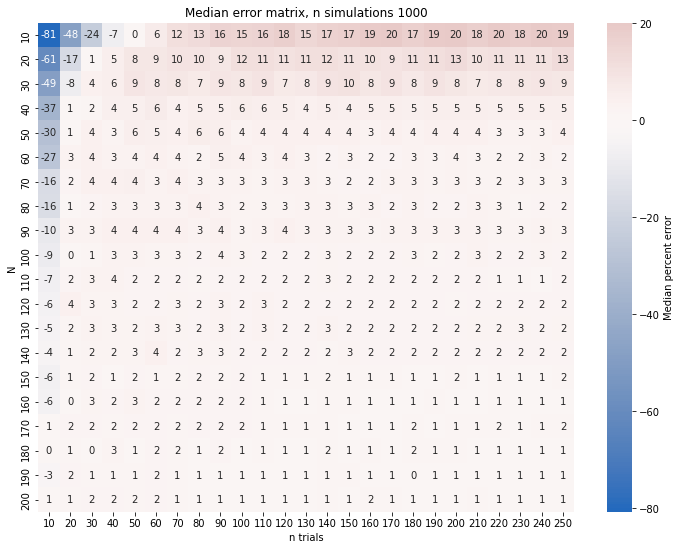

In [6]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

sns.heatmap(median_sim1000_difference_C, 
            xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
            cbar_kws={"label":"Median percent error"},
#             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            cmap=sns.color_palette("vlag", as_cmap=True),
            center=0, 
            annot=True, fmt=".0f"
           )

ax.set_ylabel('N')
ax.set_xlabel('n trials')
ax.set_title(f'Median error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()


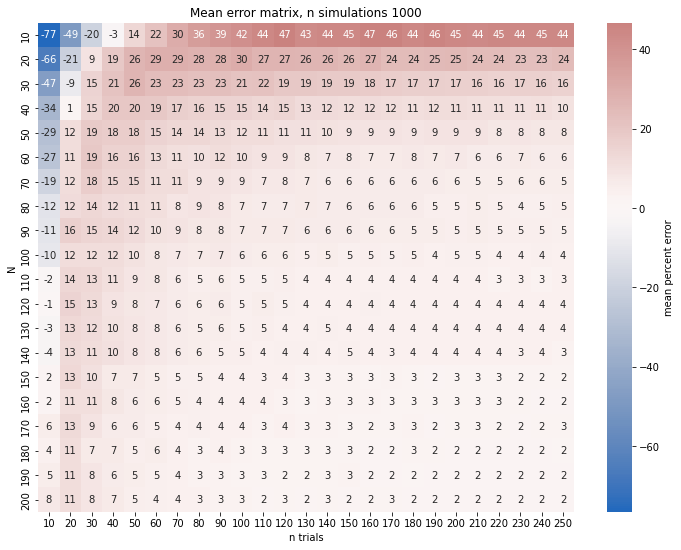

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

sns.heatmap(mean_sim1000_difference_C, 
            xticklabels=df_mean_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_mean_sim1000_noexplosions["N"].unique(),
            cbar_kws={"label":"mean percent error"},
#             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            cmap=sns.color_palette("vlag", as_cmap=True),
            center=0, 
            annot=True, fmt=".0f"
           )

ax.set_ylabel('N')
ax.set_xlabel('n trials')
ax.set_title(f'Mean error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

# plt.title(f"mean percent error in {n_simulations} simulations for {true_C_arr.min():.1f}<=C<={true_C_arr.max():.1f}")

plt.show()

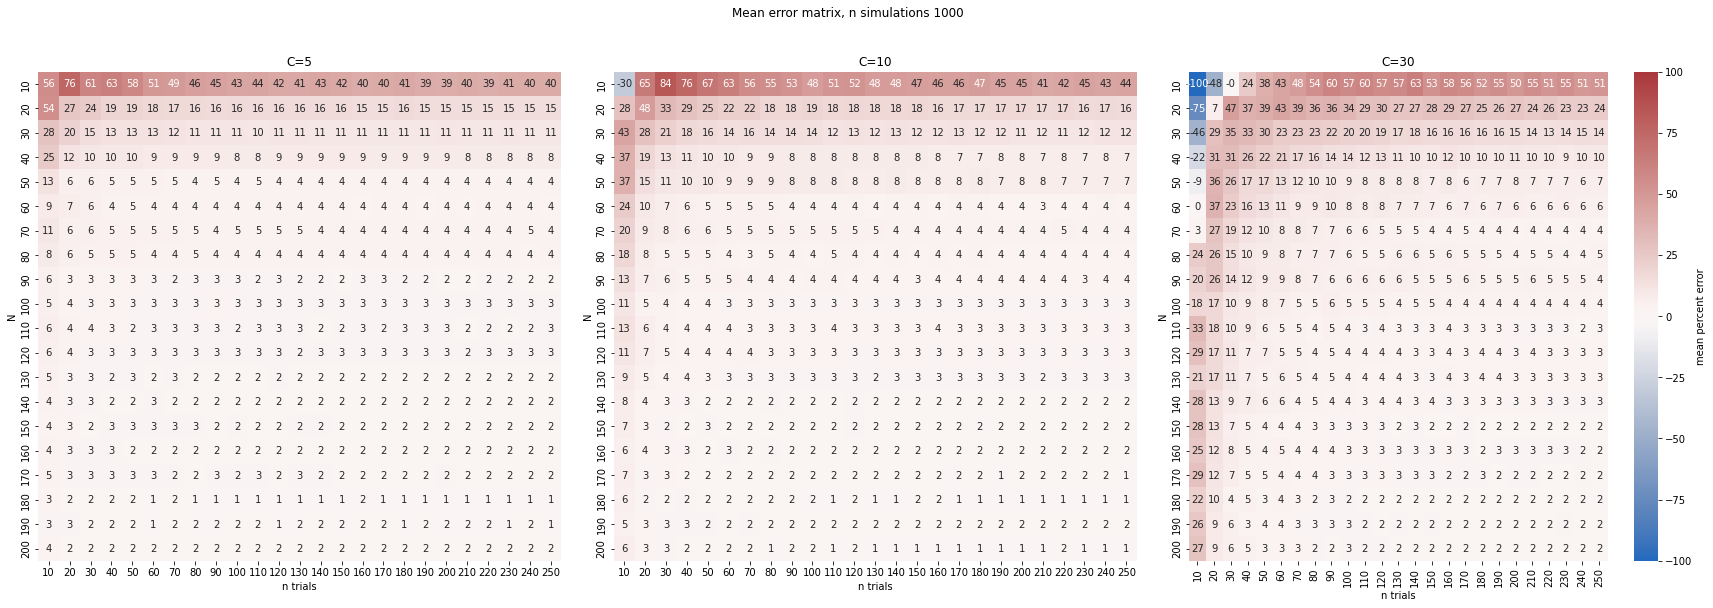

In [9]:
fig, axs = plt.subplots(1,3, figsize=(30,9))
plt.subplots_adjust(wspace=0.1)

arr = np.zeros((3, df_mean_sim1000_noexplosions["N"].unique().size, df_mean_sim1000_noexplosions["total_n_trials"].unique().size))

for j, special_C in enumerate([5, 10, 30]):
    # recreate the error matrix

    for i, N in enumerate(df_mean_sim1000_noexplosions["N"].unique()):    
        arr[j,i] = df_mean_sim1000_noexplosions.loc[(df_mean_sim1000_noexplosions["N"]==N)&(df_mean_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).mean().percent_error.values

        
    sns.heatmap(arr[j], 
                xticklabels=df_mean_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_mean_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"mean percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, vmin=-100, vmax=100,
                annot=True, fmt=".0f", 
                ax=axs[j]
               )

    axs[j].set_ylabel('N')
    axs[j].set_xlabel('n trials')
    axs[j].set_title(f'C={special_C}')
        
plt.suptitle(f'Mean error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

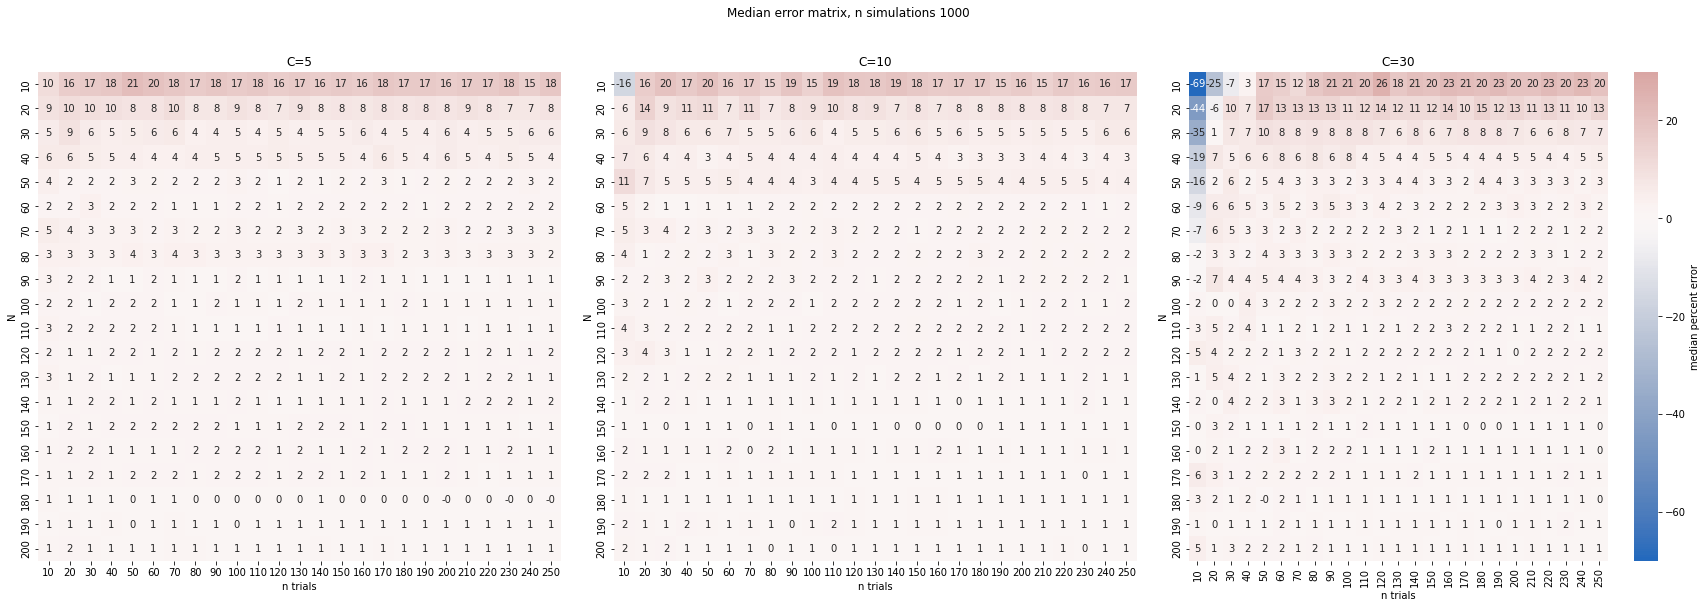

In [10]:
fig, axs = plt.subplots(1,3, figsize=(30,9))
plt.subplots_adjust(wspace=0.1)

arr = np.zeros((3, df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))

for j, special_C in enumerate([5, 10, 30]):
    # recreate the error matrix

    for i, N in enumerate(df_median_sim1000_noexplosions["N"].unique()):    
        arr[j,i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)&(df_median_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error.values

        
    sns.heatmap(arr[j], 
                xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"median percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, vmin=-70, vmax=30,
                annot=True, fmt=".0f", 
                ax=axs[j]
               )

    axs[j].set_ylabel('N')
    axs[j].set_xlabel('n trials')
    axs[j].set_title(f'C={special_C}')
        
plt.suptitle(f'Median error matrix, n simulations {df_median_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

#### STD

In [11]:
# recreate the error matrix
median_sim1000_std_difference_C = np.zeros((df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))

for i, N in enumerate(df_median_sim1000_noexplosions["N"].unique()):    
    median_sim1000_std_difference_C[i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)].groupby(["total_n_trials"]).median().percent_error_std.values
    

# recreate the error matrix
mean_sim1000_std_difference_C = np.zeros((df_mean_sim1000_noexplosions["N"].unique().size, df_mean_sim1000_noexplosions["total_n_trials"].unique().size))

for i, N in enumerate(df_mean_sim1000_noexplosions["N"].unique()):    
    mean_sim1000_std_difference_C[i] = df_mean_sim1000_noexplosions.loc[(df_mean_sim1000_noexplosions["N"]==N)].groupby(["total_n_trials"]).mean().percent_error_std.values
    


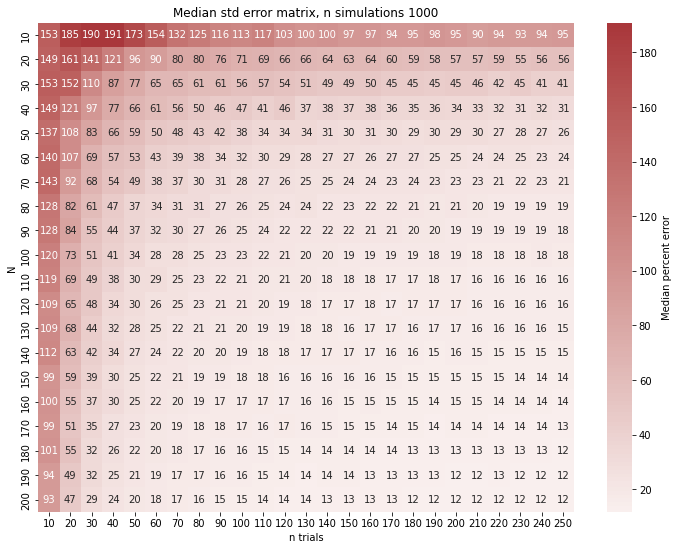

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

sns.heatmap(median_sim1000_std_difference_C, 
            xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
            cbar_kws={"label":"Median percent error"},
#             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            cmap=sns.color_palette("vlag", as_cmap=True),
            center=0, 
            annot=True, fmt=".0f"
           )

ax.set_ylabel('N')
ax.set_xlabel('n trials')
ax.set_title(f'Median std error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

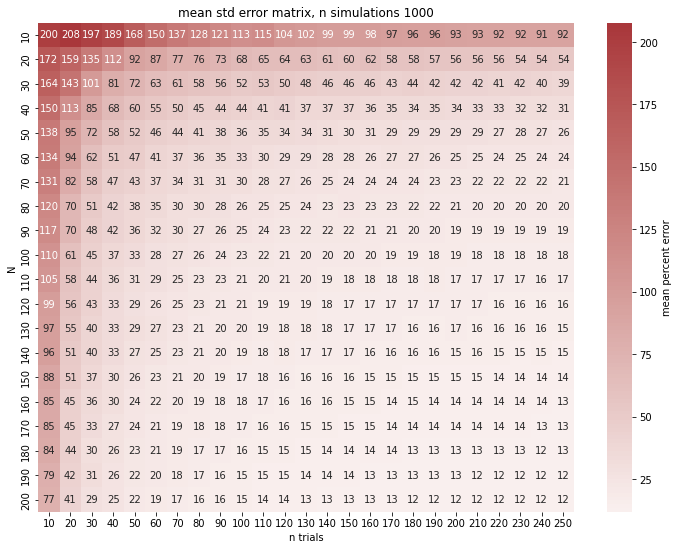

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,9))

sns.heatmap(mean_sim1000_std_difference_C, 
            xticklabels=df_mean_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_mean_sim1000_noexplosions["N"].unique(),
            cbar_kws={"label":"mean percent error"},
#             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
            cmap=sns.color_palette("vlag", as_cmap=True),
            center=0, 
            annot=True, fmt=".0f"
           )

ax.set_ylabel('N')
ax.set_xlabel('n trials')
ax.set_title(f'mean std error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

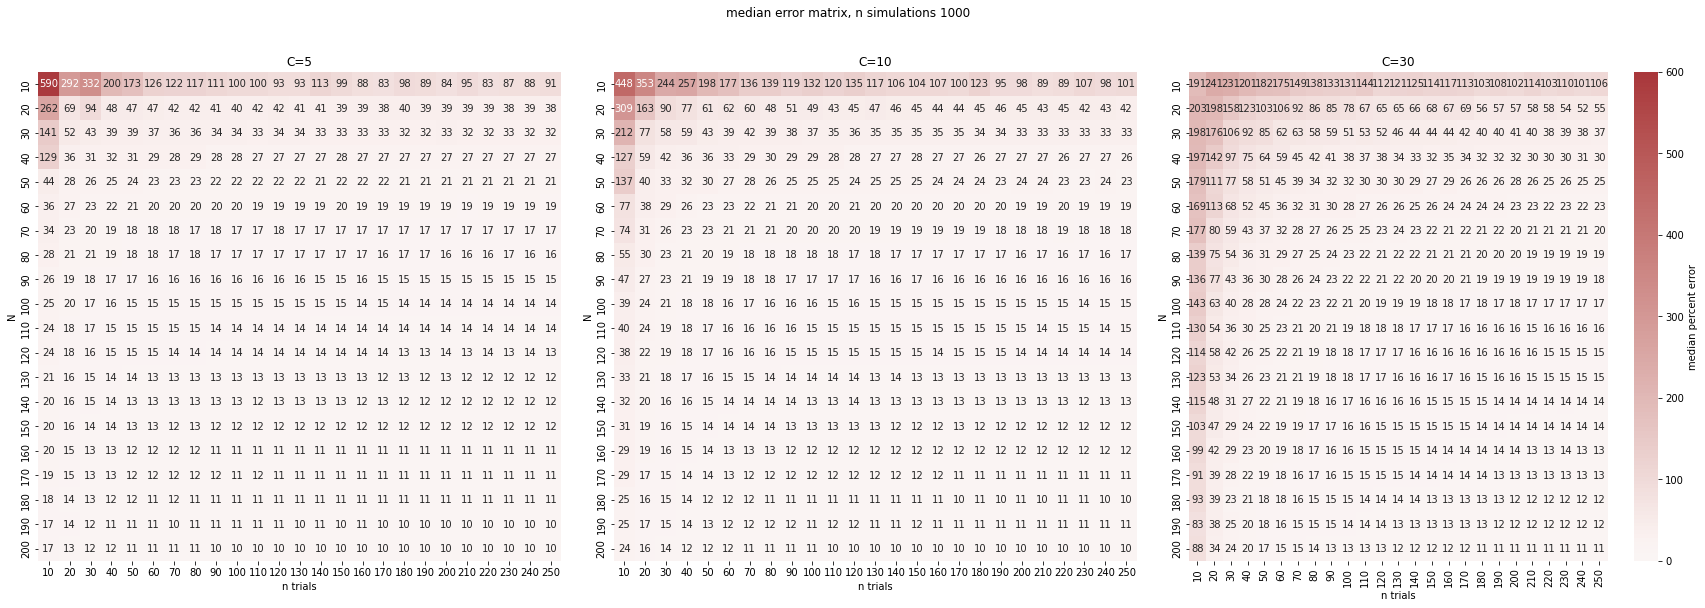

In [14]:
fig, axs = plt.subplots(1,3, figsize=(30,9))
plt.subplots_adjust(wspace=0.1)

arr = np.zeros((3, df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))

for j, special_C in enumerate([5, 10, 30]):
    # recreate the error matrix

    for i, N in enumerate(df_median_sim1000_noexplosions["N"].unique()):    
        arr[j,i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)&(df_median_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error_std.values

        
    sns.heatmap(arr[j], 
                xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"median percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, vmin=0, vmax=600,
                annot=True, fmt=".0f", 
                ax=axs[j]
               )

    axs[j].set_ylabel('N')
    axs[j].set_xlabel('n trials')
    axs[j].set_title(f'C={special_C}')
        
plt.suptitle(f'median error matrix, n simulations {df_median_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

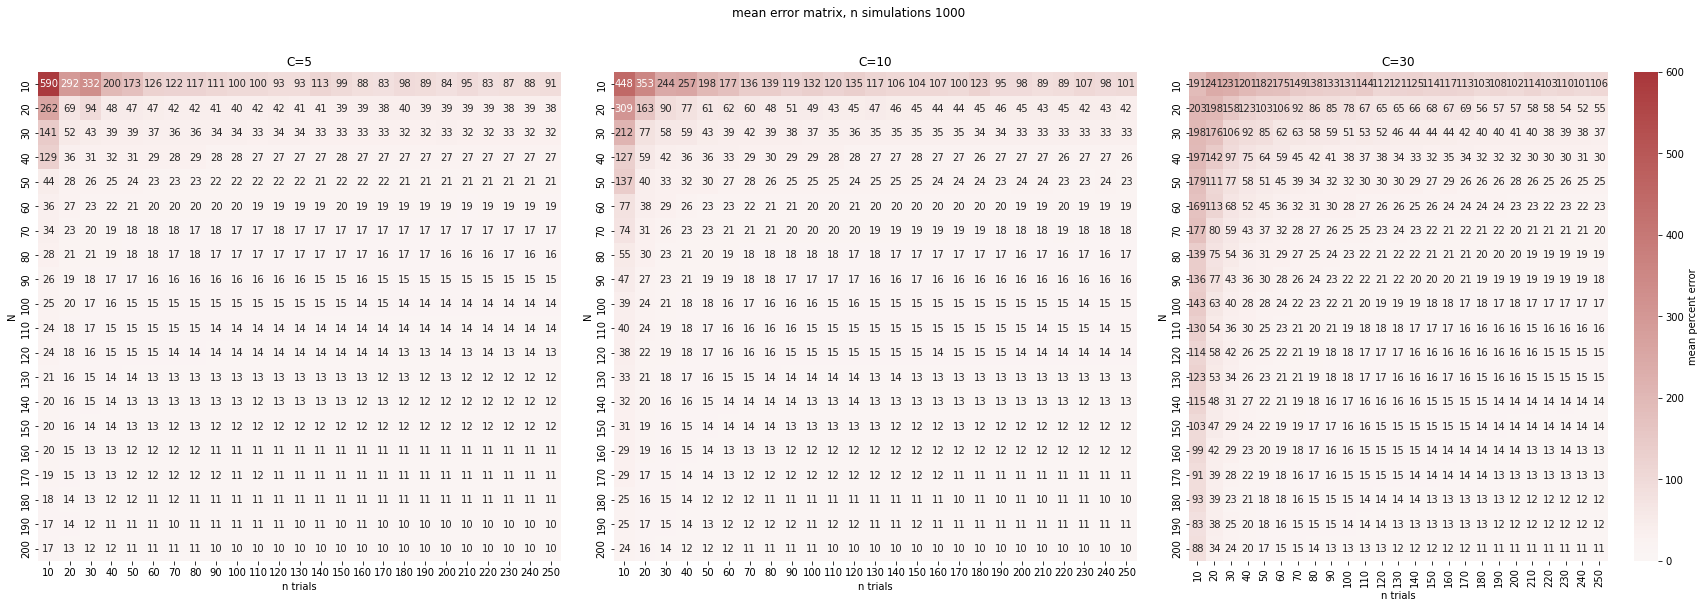

In [15]:
fig, axs = plt.subplots(1,3, figsize=(30,9))
plt.subplots_adjust(wspace=0.1)

arr = np.zeros((3, df_mean_sim1000_noexplosions["N"].unique().size, df_mean_sim1000_noexplosions["total_n_trials"].unique().size))

for j, special_C in enumerate([5, 10, 30]):
    # recreate the error matrix

    for i, N in enumerate(df_mean_sim1000_noexplosions["N"].unique()):    
        arr[j,i] = df_mean_sim1000_noexplosions.loc[(df_mean_sim1000_noexplosions["N"]==N)&(df_mean_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).mean().percent_error_std.values

        
    sns.heatmap(arr[j], 
                xticklabels=df_mean_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_mean_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"mean percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, vmin=0, vmax=600,
                annot=True, fmt=".0f", 
                ax=axs[j]
               )

    axs[j].set_ylabel('N')
    axs[j].set_xlabel('n trials')
    axs[j].set_title(f'C={special_C}')
        
plt.suptitle(f'mean error matrix, n simulations {df_mean_sim1000_noexplosions["n_sim"].unique()[0]}')

plt.show()

In [16]:
# save the matrices
total_N = df_median_sim1000_noexplosions["N"].max()
total_n_trials = df_median_sim1000_noexplosions["total_n_trials"].max()

save_name = f'unbiasedC_search_N_{total_N}xntrials_{total_n_trials}_all_arrays_nsim{df_median_sim1000_noexplosions["n_sim"].unique()[0]}_median_acrossC_test4web'
np.savez(os.path.join(path_sim, f'{save_name}.npz'),
         median_error_unbiasedC=median_sim1000_difference_C, 
         median_std_error_unbiasedC=median_sim1000_std_difference_C,
         Ns_array=df_median_sim1000_noexplosions["N"].unique(), n_trials_array=df_median_sim1000_noexplosions["total_n_trials"].unique(),
         total_N=total_N, total_n_trials=total_n_trials,
         )

#### Save matrices for selected C
[top](#top)

In [17]:
# define selection
C_selection = [4, 16, 30]

# create matrices
arr_median = np.zeros((len(C_selection), df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))
arr_std = np.zeros((len(C_selection), df_median_sim1000_noexplosions["N"].unique().size, df_median_sim1000_noexplosions["total_n_trials"].unique().size))
for j, special_C in enumerate(C_selection):
    # recreate the error matrix
    for i, N in enumerate(df_median_sim1000_noexplosions["N"].unique()):    
        arr_median[j,i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)&(df_median_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error.values
        arr_std[j,i] = df_median_sim1000_noexplosions.loc[(df_median_sim1000_noexplosions["N"]==N)&(df_median_sim1000_noexplosions["expected_C"]==special_C)].groupby(["total_n_trials"]).median().percent_error_std.values


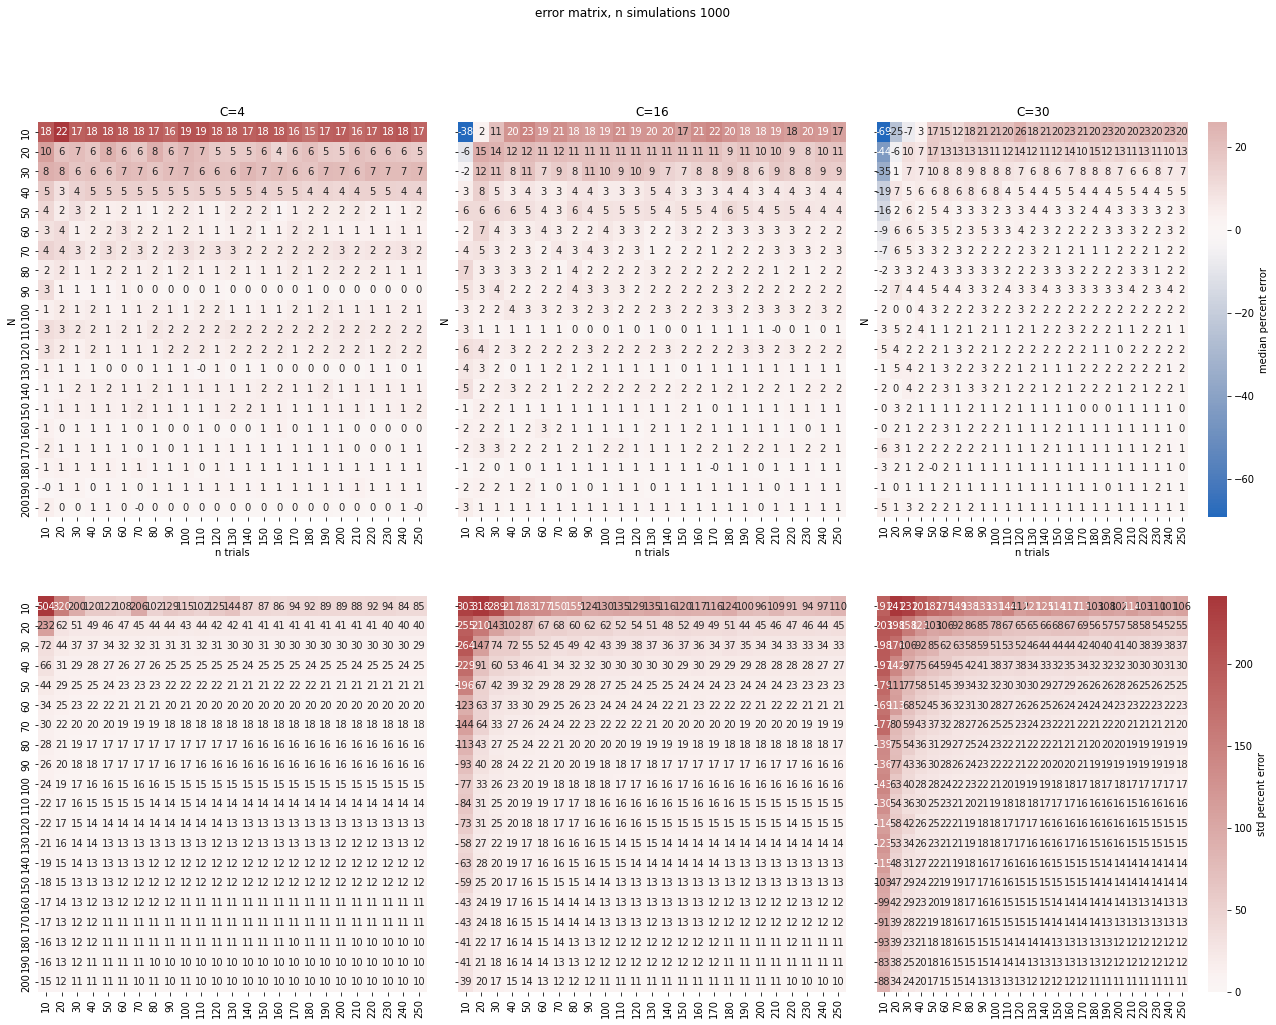

In [18]:
fig, axs = plt.subplots(2,3, figsize=(22,16), sharey=True)
plt.subplots_adjust(wspace=0.08)

for j, special_C in enumerate(C_selection):
        
    sns.heatmap(arr_median[j], 
                xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"median percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, #vmin=0, #vmax=600,
                annot=True, fmt=".0f", 
                ax=axs[0, j]
               )
    sns.heatmap(arr_std[j], 
                xticklabels=df_median_sim1000_noexplosions["total_n_trials"].unique(), yticklabels=df_median_sim1000_noexplosions["N"].unique(),
                cbar_kws={"label":"std percent error"},
                cbar=j//2,
    #             cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True),
                cmap=sns.color_palette("vlag", as_cmap=True),
                center=0, vmin=0, #vmax=600,
                annot=True, fmt=".0f", 
                ax=axs[1,j]
               )

    axs[0, j].set_ylabel('N')
    axs[0, j].set_xlabel('n trials')
    axs[0, j].set_title(f'C={special_C}')
        
plt.suptitle(f'error matrix, n simulations {df_median_sim1000_noexplosions["n_sim"].unique()[0]}')

# plt.title(f"median percent error in {n_simulations} simulations for {true_C_arr.min():.1f}<=C<={true_C_arr.maxs[j]():.1f}")

plt.show()

In [19]:
# save
save_name = f'unbiasedC_search_N_{total_N}xntrials_{total_n_trials}_all_arrays_nsim{df_median_sim1000_noexplosions["n_sim"].unique()[0]}_median_{len(C_selection)}C_selection_test4web'
np.savez(os.path.join(path_sim, f'{save_name}.npz'),
         median_error_unbiasedC=arr_median, 
         median_std_error_unbiasedC=arr_std,
         Ns_array=df_median_sim1000_noexplosions["N"].unique(), n_trials_array=df_median_sim1000_noexplosions["total_n_trials"].unique(),
         total_N=total_N, total_n_trials=total_n_trials,
         C_selection=np.asarray(C_selection),
         )

print(f'The arrays have shape {arr_median.shape}, there are the following:\nCs: {C_selection}\nNs: {df_median_sim1000_noexplosions["N"].unique()}\nn trials: {df_median_sim1000_noexplosions["total_n_trials"].unique()}')
print(f'and it was saved to {save_name}.npz')

The arrays have shape (3, 20, 25), there are the following:
Cs: [4, 16, 30]
Ns: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200]
n trials: [ 10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170 180
 190 200 210 220 230 240 250]
and it was saved to unbiasedC_search_N_200xntrials_250_all_arrays_nsim1000_median_3C_selection_test4web.npz


In [20]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv


Author: Jan Kadlec

Last updated: Mon Jun 12 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

numpy     : 1.19.1
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
pandas    : 1.2.4
matplotlib: 3.6.2
seaborn   : 0.11.1



[top](#top)